In [3]:
import re
import jsonlines
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [3]:
# Define the model
def define_model(input_vocab_size, output_vocab_size, embedding_dim, enc_units, score_fun, ATT_UNITS):
    encoder_input = tf.keras.Input(shape=(None,))
    decoder_input = tf.keras.Input(shape=(None,))
    
    encoder_embedding = Embedding(input_vocab_size, embedding_dim, mask_zero=True)(encoder_input)
    encoder_lstm = LSTM(enc_units, return_sequences=True, return_state=True)
    encoder_output, state_h, state_c = encoder_lstm(encoder_embedding)
    
    decoder_embedding = Embedding(output_vocab_size, embedding_dim, mask_zero=True)(decoder_input)
    decoder_lstm = LSTM(enc_units, return_sequences=True, return_state=True)
    decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
    
    attention = tf.keras.layers.Attention(use_scale=True)
    context_vector = attention([decoder_output, encoder_output])
    
    concat = tf.keras.layers.Concatenate(axis=-1)
    decoder_combined_input = concat([decoder_output, context_vector])
    
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    output = decoder_dense(decoder_combined_input)
    
    model = tf.keras.Model([encoder_input, decoder_input], output)
    return model

def custom_loss_function(y_true, y_pred):
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
    return loss

# Train the model# Train the model
def train_model(model, train_data, val_data, optimizer, BATCH_SIZE, epochs):
    train_steps = tf.data.experimental.cardinality(train_data).numpy() // BATCH_SIZE
    val_steps = tf.data.experimental.cardinality(val_data).numpy() // BATCH_SIZE
    
    # Ensure at least 1 step per epoch
    train_steps = max(train_steps, 1)
    val_steps = max(val_steps, 1)
    
    
    model.compile(optimizer=optimizer, loss=custom_loss_function, metrics=['accuracy'])
    
    callbacks = [
        # ModelCheckpoint(filepath="model_best.hdf5", monitor='val_loss', verbose=2, save_best_only=True, mode='auto', save_weights_only=True),
        EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5, verbose=2, mode='auto'),
        # TensorBoard(log_dir="logs/fit/")
    ]
    
    model.fit(
        train_data, 
        epochs=epochs, 
        validation_data=val_data, 
        callbacks=callbacks, 
        steps_per_epoch=train_steps, 
        validation_steps=val_steps,
        verbose=2
    )

In [4]:
def load_table_json(filePath='dataset-wikiSQL/train.jsonl'):
    id = []
    header = []
    types = []
    rows = []
    with jsonlines.open(filePath) as f:
        for line in f.iter():
            id.append((line["id"]))
            header.append((line["header"]))
            types.append((line["types"]))
            rows.append(line["rows"])

    d = {"id": id, "header": header, "types": types, "rows": rows}
    return pd.DataFrame(d)

def load_query_json(filePath='dataset-wikiSQL/train.jsonl'):
    phase=[]
    table_id=[]
    question=[]
    sql=[]
    with jsonlines.open(filePath) as f:
        for line in f.iter():
            phase.append(line["phase"])
            table_id.append(line["table_id"])
            question.append(line["question"])
            sql.append(line["sql"])
    
    d = {"phase": phase, "table_id": table_id, "question": question, "sql": sql}
    return pd.DataFrame(d)


def decontractions(phrase):

    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def decontract_text(text):

    text = text.lower()
    text = decontractions(text)
    return text

def concat_question_header(merged_data):
    merged_data['question_header'] = merged_data['header'].apply(lambda x: ' '.join(map(str, x)))
    merged_data['question_header'] = merged_data['question'] + ' ' + merged_data['question_header']
    return merged_data


def preprocess_question_header(merged_data):
    merged_data = concat_question_header(merged_data)
    merged_data['question'] = merged_data['question'].apply(lambda x: decontractions(x))
    merged_data['question_header'] = merged_data['question_header'].apply(lambda x: decontractions(x))

    return merged_data

def define_terminals(data):
    data['question_header'] = data.apply(lambda x: ' '.join([x['question']] + x['header']), axis=1)
    data['sql_input'] = '<start> ' + data['sql'].astype(str)
    data['sql_output'] = data['sql'].astype(str) + ' <end>'
    return data

def preprocess():
    # loading
    trainTables = load_table_json('dataset-wikiSQL/train.tables.jsonl')
    trainQuerys = load_query_json('dataset-wikiSQL/train.jsonl')
    
    testTables = load_table_json('dataset-wikiSQL/test.tables.jsonl')
    testQuerys = load_query_json('dataset-wikiSQL/test.jsonl')

    validTables = load_table_json('dataset-wikiSQL/dev.tables.jsonl')
    validQuerys = load_query_json('dataset-wikiSQL/dev.jsonl')
    
    trainQuerys.columns=['phase','id','question','sql']
    trainData = trainQuerys.merge(trainTables, on='id')
    
    testQuerys.columns=['phase','id','question','sql']
    testData = testTables.merge(testQuerys, on='id')

    validQuerys.columns=['phase','id','question','sql']
    validData = validTables.merge(validQuerys, on='id')

    trainData = define_terminals(preprocess_question_header(trainData))
    testData = define_terminals(preprocess_question_header(testData))
    validData = define_terminals(preprocess_question_header(validData))
    
    return (trainData, testData, validData)

    # # Merging
    # trainQuerys.columns=['phase','id','question','sql']
    # trainData = trainQuerys.merge(trainTables, on='id')

    # testQuerys.columns=['phase','id','question','sql']
    # testData = testTables.merge(testQuerys, on='id')

    # trainData = pd.concat([trainData, testData], ignore_index=True)


    # validQuerys.columns=['phase','id','question','sql']
    # testData = validTables.merge(validQuerys, on='id')

    # trainData = define_terminals(preprocess_question_header(trainData))
    # testData = define_terminals(preprocess_question_header(testData))

    # return (trainData, testData)

def tokenize_data(data, tokenizer_question, tokenizer_sql):
    question_seqs = tokenizer_question.texts_to_sequences(data['question_header'].values)
    sql_input_seqs = tokenizer_sql.texts_to_sequences(data['sql_input'].values)
    sql_output_seqs = tokenizer_sql.texts_to_sequences(data['sql_output'].values)
    return question_seqs, sql_input_seqs, sql_output_seqs

def prepare_dataset(question_seqs, sql_input_seqs, sql_output_seqs, MAX_LEN_QUESTION, MAX_LEN_SQL):
    padded_question_seqs = pad_sequences(question_seqs, maxlen=MAX_LEN_QUESTION, padding='post')
    padded_sql_input_seqs = pad_sequences(sql_input_seqs, maxlen=MAX_LEN_SQL, padding='post')
    padded_sql_output_seqs = pad_sequences(sql_output_seqs, maxlen=MAX_LEN_SQL, padding='post')
    return (padded_question_seqs, padded_sql_input_seqs), padded_sql_output_seqs


In [5]:
(trainData, testData, devData) = preprocess()

In [6]:
tokenizer_question = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer_sql = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

tokenizer_question.fit_on_texts(trainData['question_header'].values)
tokenizer_sql.fit_on_texts(trainData['sql_input'].values)

tokenizer_question.fit_on_texts(testData['question_header'].values)
tokenizer_sql.fit_on_texts(testData['sql_input'].values)

tokenizer_question.fit_on_texts(devData['question_header'].values)
tokenizer_sql.fit_on_texts(devData['sql_input'].values)

In [ ]:
print(tokenizer_question.word_index)# DOESNT MODIFY DATAFRAME
print(tokenizer_sql.word_index)

In [8]:
len(testData)

15878

In [9]:
train_question_seqs, train_sql_input_seqs, train_sql_output_seqs = tokenize_data(trainData, tokenizer_question, tokenizer_sql)
val_question_seqs, val_sql_input_seqs, val_sql_output_seqs = tokenize_data(testData, tokenizer_question, tokenizer_sql)
dev_question_seqs, dev_sql_input_seqs, dev_sql_output_seqs = tokenize_data(devData, tokenizer_question, tokenizer_sql)


In [10]:
MAX_LEN_QUESTION = 60
MAX_LEN_SQL = 35
ATT_UNITS = 64
BATCH_SIZE = 64

input_vocab_size = len(tokenizer_question.word_index) + 1
output_vocab_size = len(tokenizer_sql.word_index) + 1
embedding_dim = 100
enc_units = 64
score_fun = 'dot'


In [11]:
train_dataset = prepare_dataset(train_question_seqs, train_sql_input_seqs, train_sql_output_seqs, MAX_LEN_QUESTION, MAX_LEN_SQL)
val_dataset = prepare_dataset(val_question_seqs, val_sql_input_seqs, val_sql_output_seqs, MAX_LEN_QUESTION, MAX_LEN_SQL)
dev_dataset = prepare_dataset(dev_question_seqs, dev_sql_input_seqs, dev_sql_output_seqs, MAX_LEN_QUESTION, MAX_LEN_SQL)


In [12]:
(ques, sql_input), sql_output = dev_dataset
print(sql_input.shape)


(8421, 35)


In [13]:

train_dataset_tf = tf.data.Dataset.from_tensor_slices(train_dataset)
val_dataset_tf = tf.data.Dataset.from_tensor_slices(val_dataset)
dev_dataset_tf = tf.data.Dataset.from_tensor_slices(dev_dataset)

# Shuffle and batch the datasets
train_dataset_tf = train_dataset_tf.shuffle(buffer_size=len(train_dataset_tf)).batch(BATCH_SIZE)
val_dataset_tf = val_dataset_tf.batch(BATCH_SIZE)

In [14]:
model = define_model(input_vocab_size, output_vocab_size, embedding_dim, enc_units, score_fun, ATT_UNITS)


In [ ]:
# loss_function = custom_loss_function
learning_rate = 3e-4
optimizer = tf.keras.optimizers.Adam(learning_rate)
BATCH_SIZE = 64
epochs = 20

# Train the model using the TensorFlow Dataset objects

train_model(model, train_dataset_tf, val_dataset_tf, optimizer, BATCH_SIZE, epochs)


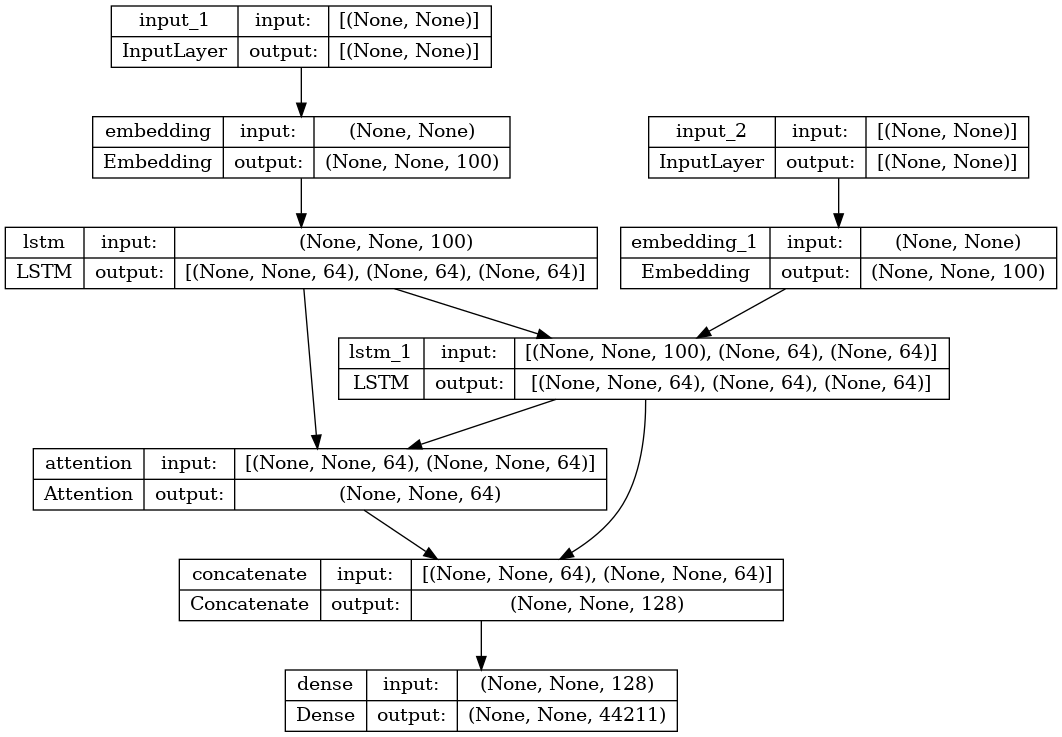

In [16]:
# tf.keras.utils.plot_model(model)

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
predictions = model.evaluate(dev_dataset)


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 100)            4175800   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 100)            4421100   ['input_2[0][0]']             
                                                                                              